In [4]:
# import the library
import os
import csv
import time
import json
import numpy as np
import pandas as pd
import string
# import mlflow
import json
import pickle
import tensorflow as tf

from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score,
                             precision_score,
                             recall_score, 
                             accuracy_score)

In [5]:
# import the library
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional

In [6]:
# read dataset
trainset_path = '/content/train_dataset.csv'
testset_path = '/content/test_dataset.csv'

train_df = pd.read_csv(trainset_path)
test_df = pd.read_csv(testset_path)

train_df.isna().sum()
train_df.isnull().sum()
train_df.isna().sum()
test_df.isnull().sum()

train_df = train_df.fillna('unknown')
test_df = test_df.fillna('unknown')

In [7]:
len(train_df['LABEL'].unique())

41

In [8]:
train_df

,TEXT,LABEL
0,stomach pain acidity ulcers on tongue vomiting...,gerd
1,chills fatigue cough high fever sweating malai...,pneumonia
2,vomiting headache nausea spinning movements lo...,vertigo-paroymsal--positional-vertigo
3,weight loss restlessness lethargy irregular su...,diabetes
4,skin rash pus filled pimples blackheads scurring,acne
...,...,...
3439,vomiting indigestion loss of appetite abdomina...,peptic-ulcer-diseae
3440,chills vomiting sweating headache nausea diarr...,malaria
3441,skin rash joint pain skin peeling silver like ...,psoriasis
3442,joint pain vomiting fatigue high fever yellowi...,hepatitis-e


In [9]:
# define train test data
X_train, X_val, y_train, y_val = train_test_split(
                                          train_df['TEXT'],
                                          train_df['LABEL'], 
                                          test_size=0.2,
                                          stratify=train_df["LABEL"],
                                          random_state = 42
    )

In [10]:
X_test = test_df['TEXT']
y_test = test_df['LABEL']

In [11]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [12]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=64, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=64, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=64, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 209


In [108]:
# Build neural network architecture
import tensorflow as tf
tf.keras.backend.clear_session()

adam = Adam(learning_rate=0.005)
#code here
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabSize, 200, input_length=X_train.shape[1], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(41, activation='softmax'),
    tf.keras.layers.Dropout(0.5)
    ])

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 200)           41800     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              135680    
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
 dense_1 (Dense)             (None, 8)                 40        
                                                                 
 dense_2 (Dense)             (None, 24)                216       
                                                                 
 dense_3 (Dense)             (None, 41)                1025      
                                                        

In [90]:
#Callback
callback = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=10,
    restore_best_weights=True
)

In [91]:
# Fit model
# code here
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=64,
                    callbacks=[callback],
                    epochs=20)

Epoch 1/20
44/44 [==============================] - 6s 134ms/step - loss: 8.0451 - accuracy: 0.4987 - val_loss: 0.1000 - val_accuracy: 0.9739
Epoch 2/20
44/44 [==============================] - 10s 228ms/step - loss: 7.9675 - accuracy: 0.4900 - val_loss: 0.5598 - val_accuracy: 0.8128
Epoch 3/20
44/44 [==============================] - 8s 185ms/step - loss: 8.1440 - accuracy: 0.4650 - val_loss: 0.5421 - val_accuracy: 0.8026
Epoch 4/20
44/44 [==============================] - 6s 142ms/step - loss: 8.4897 - accuracy: 0.3887 - val_loss: 0.3374 - val_accuracy: 0.8868
Epoch 5/20
44/44 [==============================] - 6s 138ms/step - loss: 8.1899 - accuracy: 0.4704 - val_loss: 0.1700 - val_accuracy: 0.9637
Epoch 6/20
44/44 [==============================] - 6s 144ms/step - loss: 8.3346 - accuracy: 0.4788 - val_loss: 0.1070 - val_accuracy: 0.9710
Epoch 7/20
44/44 [==============================] - 6s 141ms/step - loss: 7.7960 - accuracy: 0.5125 - val_loss: 0.0614 - val_accuracy: 0.9942
Epoch

In [92]:
model.evaluate(X_test, y_test, verbose=1)

47/47 [==============================] - 1s 24ms/step - loss: 0.0350 - accuracy: 0.9986


[0.03502649441361427, 0.998645007610321]

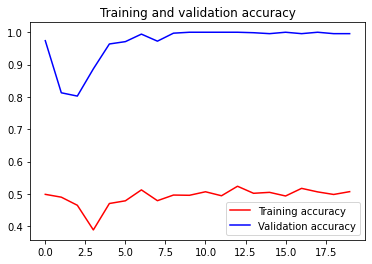

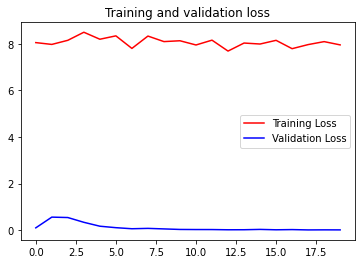

In [93]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [94]:
# save model
import numpy as np
import pickle

model.save('model/model-tensorflow.h5')

np.save('model/classes_encoder.npy', le.classes_)

pickle.dump(tokenizer, open('model/tokenizer.pkl', 'wb'))

In [95]:
# Classify custom sample

sentences = [
            "stomach pain acidity ulcers on tongue"
            ]
for sentence in sentences:
    print(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=64, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n")

stomach pain acidity ulcers on tongue
drug-reaction : 0.47684377431869507



In [96]:
# Tokenizing
sentence = "itching"
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=64, truncating='pre')
pred = model.predict(sentence)
np.argmax(pred, axis=-1)

array([0])

In [97]:
np.max(pred)

0.566385

In [98]:
preds = tf.math.top_k(pred, k=3)

In [99]:
preds[0][0].numpy().tolist()

[0.5663849711418152, 0.31503453850746155, 0.06822872161865234]

In [100]:
preds[1][0].numpy()

array([ 0, 17, 15], dtype=int32)

In [101]:
# le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))
# tf.math.top_k(pred, k=3)

pred_1 = le.inverse_transform(preds[1][0].numpy())
# pred_2 = le.inverse_transform(preds[1][0].numpy()[1])
# pred_3 = le.inverse_transform(preds[1][0].numpy()[2])

In [102]:
pred_1

array(['acne', 'heart-attack', 'gastroenteritis'], dtype=object)

In [103]:
model_tf = tf.keras.models.load_model('model/model-tensorflow.h5')

In [104]:
tokenizer = pickle.load(open('model/tokenizer.pkl', 'rb'))
le = LabelEncoder()
le.classes_ = np.load('model/classes_encoder.npy', allow_pickle=True)

text = tokenizer.texts_to_sequences(['skin rash chills joint pain vomiting fatigue'])
text = pad_sequences(text, maxlen=64, truncating='pre')
pred = model_tf.predict(text)
preds = tf.math.top_k(pred, k=3)
list_predictions = le.inverse_transform(preds[1][0].numpy())
list_score = preds[0][0].numpy().tolist()

In [105]:
list_predictions

array(['aids', 'arthritis', 'hypertension-'], dtype=object)

In [106]:
list_predictions

array(['aids', 'arthritis', 'hypertension-'], dtype=object)

In [107]:
list_score

[0.8323832154273987, 0.14456205070018768, 0.012576776556670666]